In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import json
import os
import sys

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from vvc import config
from vvc.detector import object_detection

In [5]:
dataset_folder = config.video_folder

model_name = 'frcnn-resnet50'

experiment_folder = os.path.join(config.base_folder, 'Videos', 'vvc')

video_name = 'CL 53 X CRA 60 910-911'

file_extension = '.mp4.json'

test_file = os.path.join(dataset_folder, 'cvat', video_name + '.xml')
experiment_file = os.path.join(experiment_folder, video_name, model_name + file_extension)

experiment_file

'/home/juan/workspace/Maestria/Videos/vvc/CL 53 X CRA 60 910-911/frcnn-resnet50.mp4.json'

In [6]:
def vott_to_dataframe(json_file):
    test_annotations = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)

        for frame_id, boxes in data['frames'].items():
            if not frame_id in test_annotations:
                test_annotations[frame_id] = {}
            for box in boxes:
                for tag in box['tags']:
                    if not tag in test_annotations[frame_id]:
                        test_annotations[frame_id][tag] = 0
                    test_annotations[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.drop(columns=['ignore'])
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df
    
#test = vott_to_dataframe(test_file)
#test.iloc[4:].head()

In [7]:
import xml.etree.ElementTree as ET


def counts_cvat_to_df(in_file):
    '''
    
    '''
    test_annotations = {}
    df = pd.DataFrame()
    
    tree=ET.parse(in_file)
    annotations = tree.getroot()
    
    for track in annotations.iter('track'):
        if track.attrib['label'] == 'vehicle':
            for box in track:
                frame_id = box.get('frame')
                if not frame_id in test_annotations:
                    test_annotations[frame_id] = {}
                    v_type = None
                    lr_side = None
                    fb_side = None
                for attribute in box:
                    if attribute.get('name') == 'type':
                        v_type = attribute.text
                    elif attribute.get('name') == 'LR_side':
                        lr_side = attribute.text
                    elif attribute.get('name') == 'FB_side':
                        fb_side = attribute.text if attribute.text != '__undefined__' else 'back'
                tag = v_type #+ '_' + fb_side + '_' + lr_side
                
                if not tag in test_annotations[frame_id]:
                    test_annotations[frame_id][tag] = 0
                test_annotations[frame_id][tag] += 1
                    

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df

test = counts_cvat_to_df(test_file)
test.iloc[100:].head()


FileNotFoundError: [Errno 2] No such file or directory: '/home/juan/workspace/Maestria/Videos/Original/cvat/CL 53 X CRA 60 910-911.xml'

In [9]:
from vvc.format.vvc_format import to_df
    
experiment, times = to_df(experiment_file)

times.iloc[:].head()

,detection,postprocessing,preprocessing,read,tracking,total
0,353.377,61.920,3.018,13.625,0.045,431.985
1,372.797,5.808,3.363,2.553,0.077,384.598
10,355.468,5.401,4.297,1.905,0.111,367.182
100,362.491,5.265,4.109,1.724,0.066,373.655
1000,359.599,5.093,4.070,2.649,0.061,371.472


In [11]:
def calc_precision(test, experiment): 
    
    # Combine using function    
    min_combined = test.combine(experiment, np.minimum, fill_value=0)
        
    exp_combined = test.combine(experiment, lambda s1, s2: s2, fill_value=0)
    
    equal_combined = test.combine(experiment, np.equal, fill_value=False)
    
            
    precision = min_combined.div(exp_combined)
    
    precision[equal_combined == True] = 1

    precision = precision.fillna(0)
    
    
    precision.sort_index(inplace=True, kind='mergesort')

    return precision

def calc_recall(test, experiment): 
    
    # Combine using function    
    min_combined = test.combine(experiment, np.minimum, fill_value=0)
        
    test_combined = test.combine(experiment, lambda s1, s2: s1, fill_value=0)
    
    equal_combined = test.combine(experiment, np.equal, fill_value=False)
    
            
    recall = min_combined.div(test_combined)
    
    recall[equal_combined == True] = 1

    recall = recall.fillna(0)
    
    
    recall.sort_index(inplace=True, kind='mergesort')

    return precision

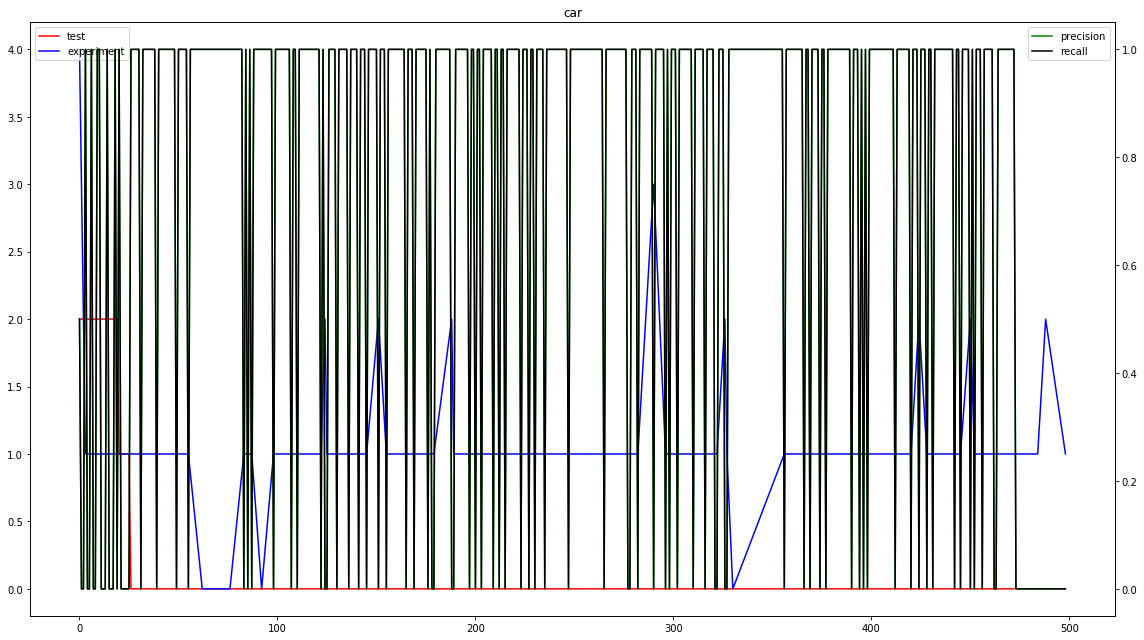

In [12]:
precision = calc_precision(test, experiment)

recall = calc_recall(test, experiment)

def plot_precision(vehicle='car', max_index=500):

    sub_test = test.loc[test.index <= max_index, vehicle]
    sub_predicted = experiment.loc[experiment.index <= max_index, vehicle]
    sub_precision = precision.loc[precision.index <= max_index, vehicle]
    sub_recall = recall.loc[recall.index <= max_index, vehicle]

    fig, ax = plt.subplots(figsize=(16, 9))

    plt.title(vehicle)

    ax.plot(sub_test.index, sub_test, label='test', color='r')

    ax.plot(sub_predicted.index, sub_predicted, label='experiment', color='b')
    
    ax.legend(loc='upper left')

    
    ax2 = ax.twinx()

    ax2.plot(sub_precision.index, sub_precision, label='precision', color='g')

    ax2.plot(sub_recall.index, sub_recall, label='recall', color='k')

    ax2.legend()

    plt.tight_layout()

    
plot_precision()

In [13]:
def compare_models(test_df, models):

    avg_precision = pd.DataFrame(index=test.columns)
    avg_p = pd.DataFrame(columns=models)

    avg_fps = pd.DataFrame(index=['1066x600'])
    avg_time = pd.DataFrame(index=['preprocessing', 'detection', 'tracking', 'postprocessing'])

    for model in models:
        print('model: ', model)
        experiment_folder = os.path.join(config.base_folder, 'Videos', 'vvc', video_name)
        experiment_file = os.path.join(experiment_folder, model.value + '.mp4.json')

        experiment, times = to_df(experiment_file)

        precision = calc_precision(test, experiment)

        mean_precision = precision.mean().to_frame(model)

        avg_precision = avg_precision.join(mean_precision)

        avg_p.loc['avg_p', model] = precision.melt().mean()['value']

        # times

        mean_time = times[avg_time.index].mean().to_frame(model)

        avg_time = avg_time.join(mean_time)

        # fps

        total = times['total']

        fps = (total.count() / total.sum()) * 1000

        avg_fps[model] = fps

        avg_p.loc['balance', model] = avg_p.loc['avg_p', model] * fps
        
    return avg_precision, avg_time, avg_fps, avg_p

# dispay
test = counts_cvat_to_df(test_file)
models = object_detection.basic_models

avg_precision, avg_time, avg_fps, avg_p = compare_models(test, models)

display(avg_precision)

display(avg_time)

avg_fps

model:  Detector.FRCNN
model:  Detector.FRCNN_TRANSFER
model:  Detector.YOLO3
model:  Detector.YOLO3_TRANSFER
model:  Detector.YOLO3_PRUNNED
model:  Detector.TINY_YOLO3
model:  Detector.TINY_YOLO3_TRANSFER
model:  Detector.RETINANET


,Detector.FRCNN,Detector.FRCNN_TRANSFER,Detector.YOLO3,Detector.YOLO3_TRANSFER,Detector.YOLO3_PRUNNED,Detector.TINY_YOLO3,Detector.TINY_YOLO3_TRANSFER,Detector.RETINANET
motorbike,0.452802,0.267191,0.488432,0.362041,0.324275,0.453079,0.211416,0.482663
bus,0.774336,0.721022,0.787918,0.773525,0.742754,0.769795,0.699789,0.776006
truck,0.629794,0.506876,0.615681,0.599681,0.545290,0.608504,0.469345,0.584605
car,0.581858,0.874263,0.594198,0.719298,0.807971,0.614370,0.945032,0.620280


,Detector.FRCNN,Detector.FRCNN_TRANSFER,Detector.YOLO3,Detector.YOLO3_TRANSFER,Detector.YOLO3_PRUNNED,Detector.TINY_YOLO3,Detector.TINY_YOLO3_TRANSFER,Detector.RETINANET
preprocessing,4.125211,4.127032,4.677802,4.841815,4.735569,4.740037,5.050959,4.637108
detection,356.000770,382.772049,41.489000,37.107476,41.022781,21.128828,16.300243,86.781202
tracking,0.061328,0.022787,0.793492,0.098285,0.032392,0.249234,0.014107,0.129070
postprocessing,4.432110,3.917010,4.907020,3.985207,3.920114,4.466287,3.311236,4.556413


,Detector.FRCNN,Detector.FRCNN_TRANSFER,Detector.YOLO3,Detector.YOLO3_TRANSFER,Detector.YOLO3_PRUNNED,Detector.TINY_YOLO3,Detector.TINY_YOLO3_TRANSFER,Detector.RETINANET
1066x600,2.725465,2.543352,18.465915,20.693976,19.234633,30.404517,36.86444,10.160843


In [14]:
display(avg_p)

best_precision_model = avg_p.sort_values(by ='avg_p', axis=1, ascending=False).columns[0]

print('best precision model: ', best_precision_model)

best_balance_model = avg_p.sort_values(by ='balance', axis=1, ascending=False).columns[0]

print('best balance model: ', best_balance_model)

,Detector.FRCNN,Detector.FRCNN_TRANSFER,Detector.YOLO3,Detector.YOLO3_TRANSFER,Detector.YOLO3_PRUNNED,Detector.TINY_YOLO3,Detector.TINY_YOLO3_TRANSFER,Detector.RETINANET
avg_p,0.609698,0.592338,0.694675,0.613636,0.605072,0.611437,0.581395,0.690214
balance,1.66171,1.50652,12.8278,12.6986,11.6383,18.5904,21.4328,7.01316


best precision model:  Detector.YOLO3
best balance model:  Detector.TINY_YOLO3_TRANSFER


<Figure size 432x288 with 0 Axes>

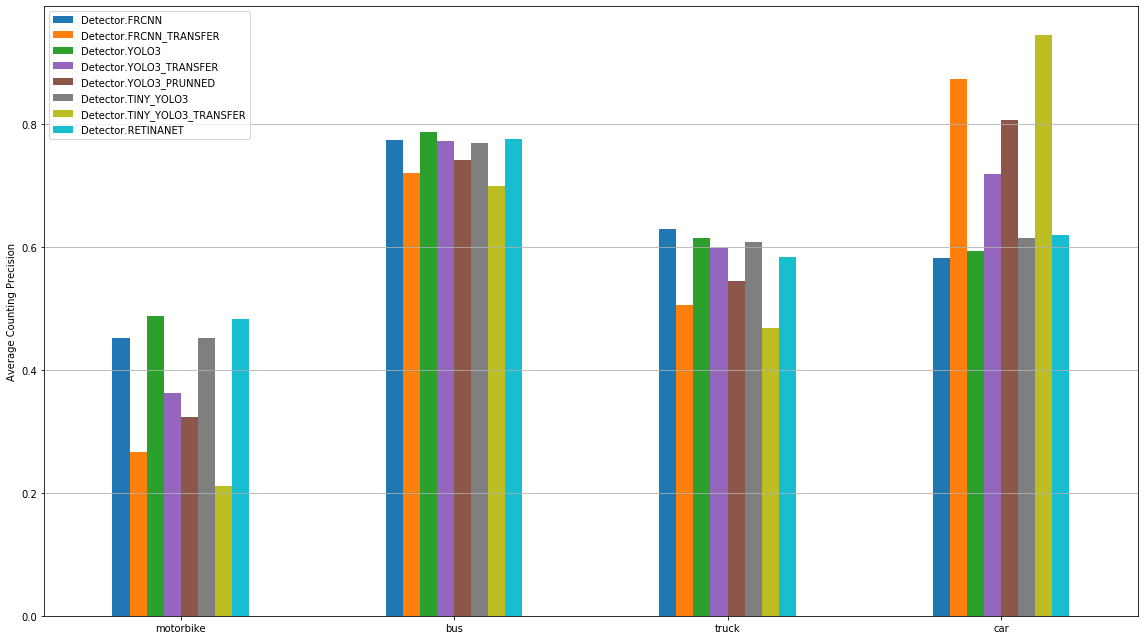

In [15]:
def plot_avg_precision(avg_precision, prefix='basic', cmap=plt.cm.tab10):
    plt.figure()

    ax = avg_precision.plot.bar(figsize=(16, 9), rot=0, cmap=cmap)

    plt.grid(axis='y')

    ax.set_ylabel('Average Counting Precision')

    plt.tight_layout()

    fig = ax.get_figure()
    fig.savefig('./img/{}_avg_precision.png'.format(prefix))
    #fig.savefig('./img/{}avg_precision.tif', dpi=300)

    
plot_avg_precision(avg_precision)

<Figure size 432x288 with 0 Axes>

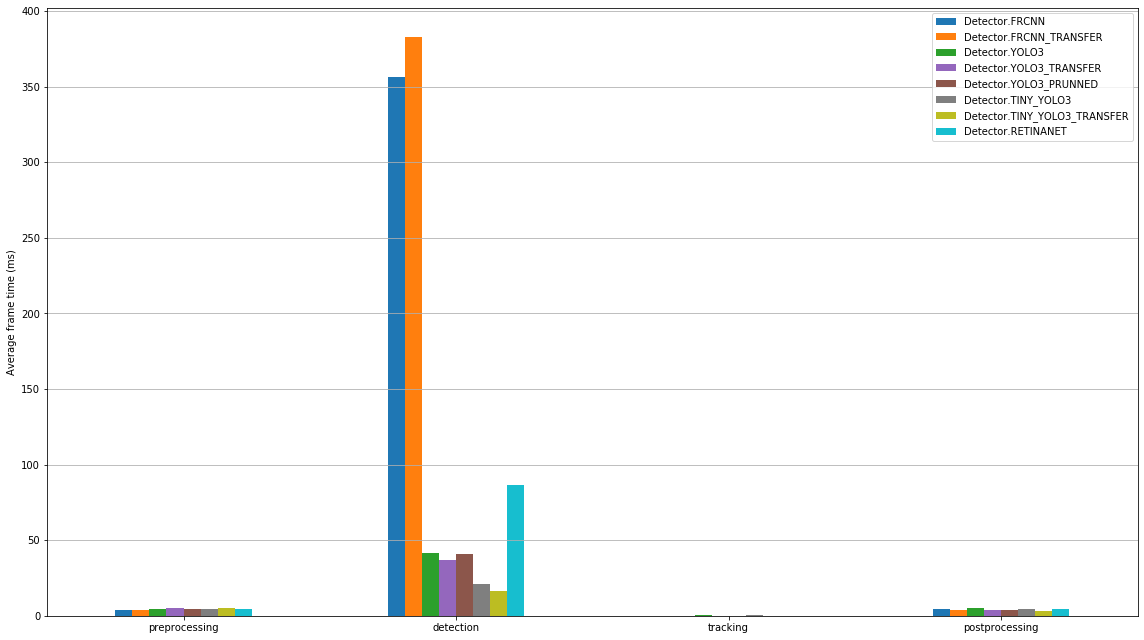

In [16]:
def plot_avg_time(avg_time, prefix='basic', cmap=plt.cm.tab10):
    plt.figure()

    ax = avg_time.plot.bar(figsize=(16, 9), rot=0, cmap=cmap)

    plt.grid(axis='y')

    ax.set_ylabel('Average frame time (ms)')

    plt.tight_layout()

    fig = ax.get_figure()
    fig.savefig('./img/{}_avg_time.png'.format(prefix))

plot_avg_time(avg_time)

<Figure size 432x288 with 0 Axes>

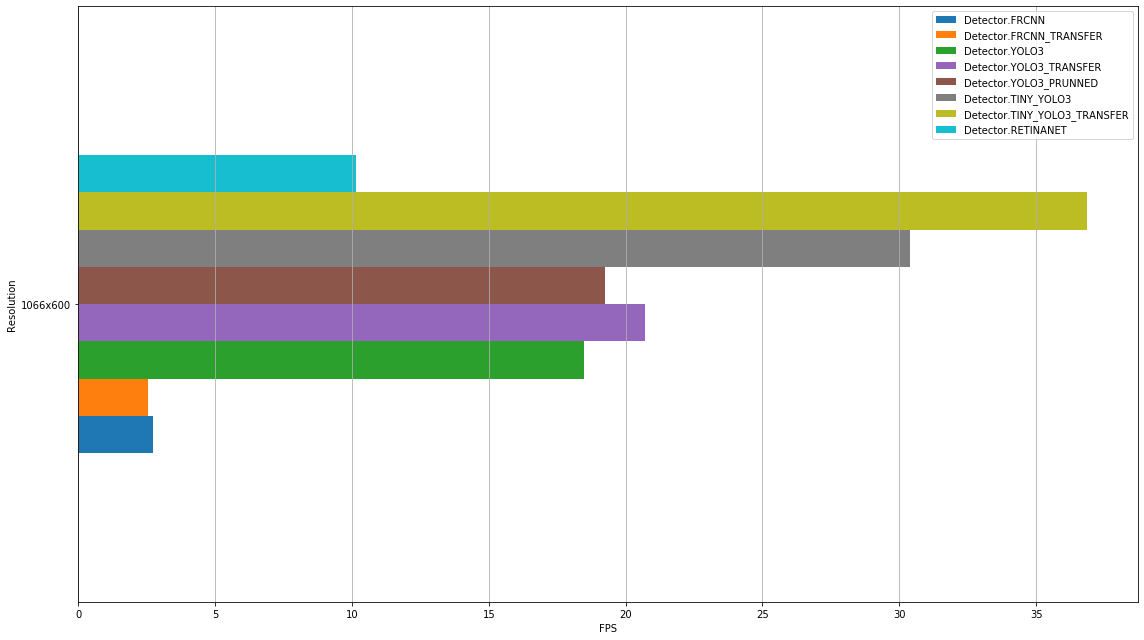

In [17]:
def plot_avg_fps(avg_fps, prefix='basic', cmap=plt.cm.tab10):
    plt.figure()

    ax = avg_fps.plot.barh(figsize=(16, 9), cmap=cmap)

    plt.grid(axis='x')

    ax.set_ylabel('Resolution')
    ax.set_xlabel('FPS')

    plt.tight_layout()

    fig = ax.get_figure()
    fig.savefig('./img/{}_avg_fps.png'.format(prefix), dpi=300)
    
plot_avg_fps(avg_fps)

model:  Detector.YOLO3
model:  Detector.TINY_YOLO3_TRANSFER
model:  Detector.VVC1
model:  Detector.VVC2
model:  Detector.VVC3


<Figure size 432x288 with 0 Axes>

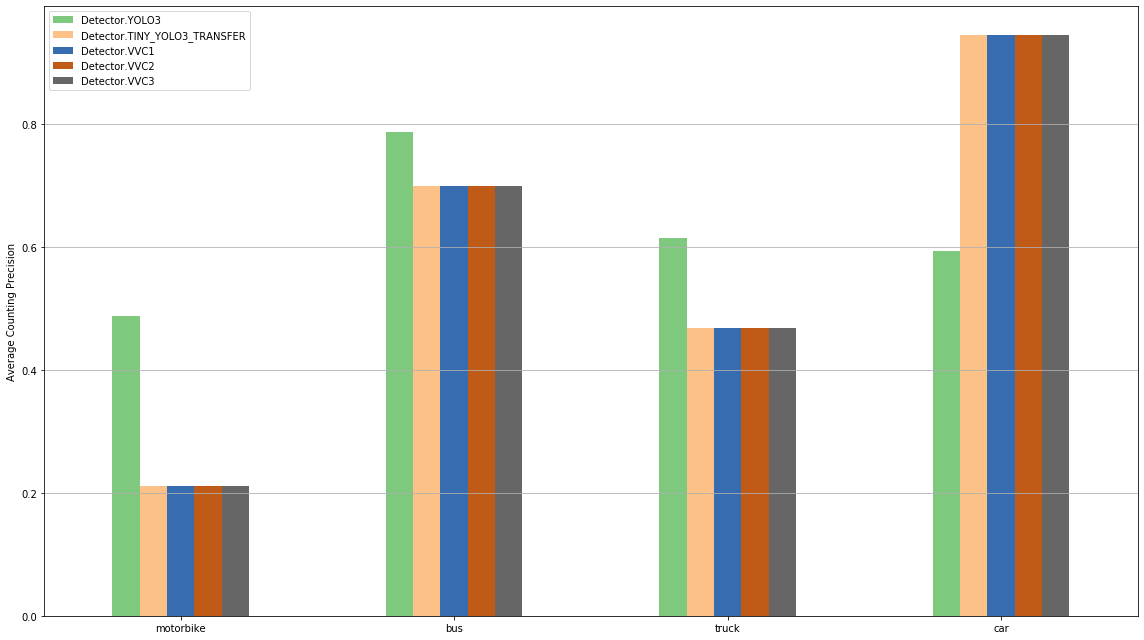

<Figure size 432x288 with 0 Axes>

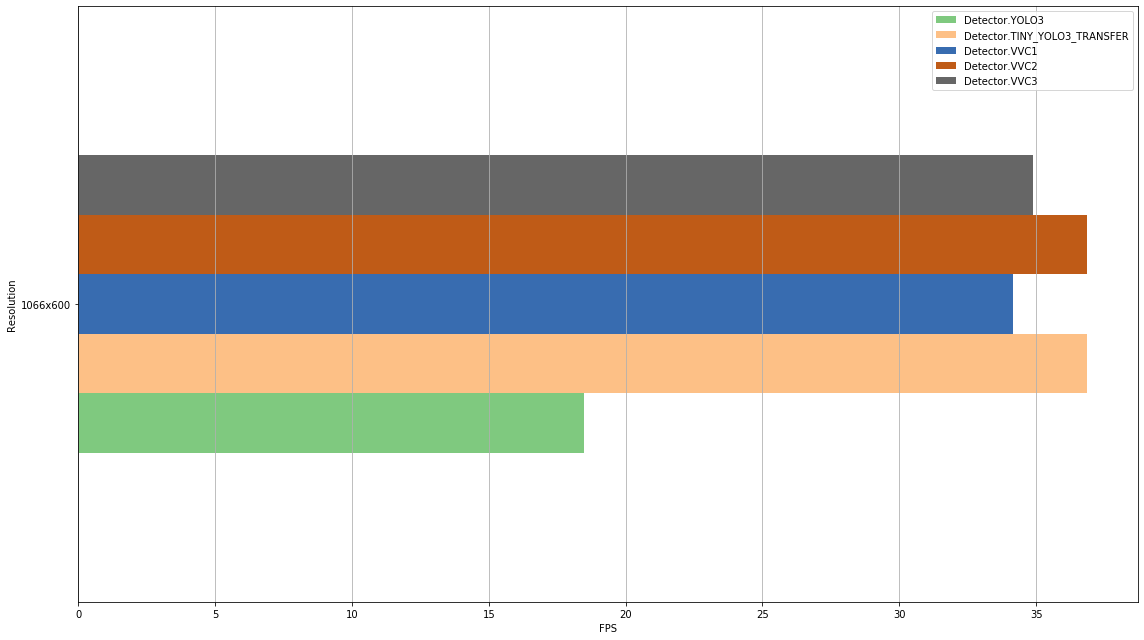

In [18]:
custom_models = [best_precision_model, best_balance_model] + object_detection.vvc_models 

avg_precision, avg_time, avg_fps, avg_p = compare_models(test, custom_models)

prefix = 'custom'

cmap = plt.cm.Accent

plot_avg_precision(avg_precision, prefix, cmap)
#plot_avg_time(avg_time, prefix)
plot_avg_fps(avg_fps, prefix, cmap)